In [1]:
from functools import partial
import logging

import pandas as pd, dask.dataframe as dd
import numpy as np

from scipy.stats.mstats import winsorize
from arch import arch_model
from arch.__future__ import reindexing

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (28, 6)
plt.style.use("ggplot")

from residualisation import rolling_df_to_series

logger = logging.getLogger(__name__)

## Data Preparation

In [2]:
USECOLS = usecols=("time", "open", "close", "high", "low", "volume", "pair_name", "date")

In [3]:
data = dd.read_csv("data/*", usecols=USECOLS)

daily_prices = data.groupby(["date", "pair_name"]).last()["close"].compute()
daily_prices = daily_prices.reset_index().pivot(values="close", index="date", columns="pair_name")
daily_prices.index = pd.to_datetime(daily_prices.index)

In [4]:
def winsorize_df(df, quantile):
    """Apply winsorization to a dataframe."""
    wins = winsorize(df.values, limits=(quantile, quantile))
    return pd.DataFrame(wins, columns=df.columns, index=df.index)

In [28]:
log_returns = np.log(1 + daily_prices.pct_change())
log_returns = winsorize_df(log_returns, quantile=0.01)
log_returns = log_returns.replace(0, np.nan)

GARCH is used to model (log) returns over time since, unlike traditional (S)AR(I)MA modelling, it accounts for heteroskedasticity which is often present due to the fluctuating volatility of financial markets. The most general model, the GARCH($p$,$q$) model, is specified for a series of returns $(r_t)_{t\geq0}$ as follows:

$$
r_t = \mu + \varepsilon_t, \\
\varepsilon_t = \sigma_t e_t, \\
\sigma_t^2 = \omega + \sum_{i=1}^p\alpha_i\varepsilon_{t-i}^2 + \sum_{i=1}^q\beta_i\sigma_{t-i}^2.
$$

## Visualisation

We should check that the variance of our returns are indeed autocorrelated.

In [6]:
def autocorr_plots(df, bins=50):
    fig, axs = plt.subplots(2, 2, figsize=(28, 16))
    lags = (1, 2, 5, 10)
    for k, ax in enumerate(axs.ravel()):
        lag = lags[k]
        autocorrs = df.corrwith(df.shift(lag))
        autocorrs.plot.hist(bins=bins, ax=ax)
        ax.set_title(f"Lag = {lag}")
    return fig, axs

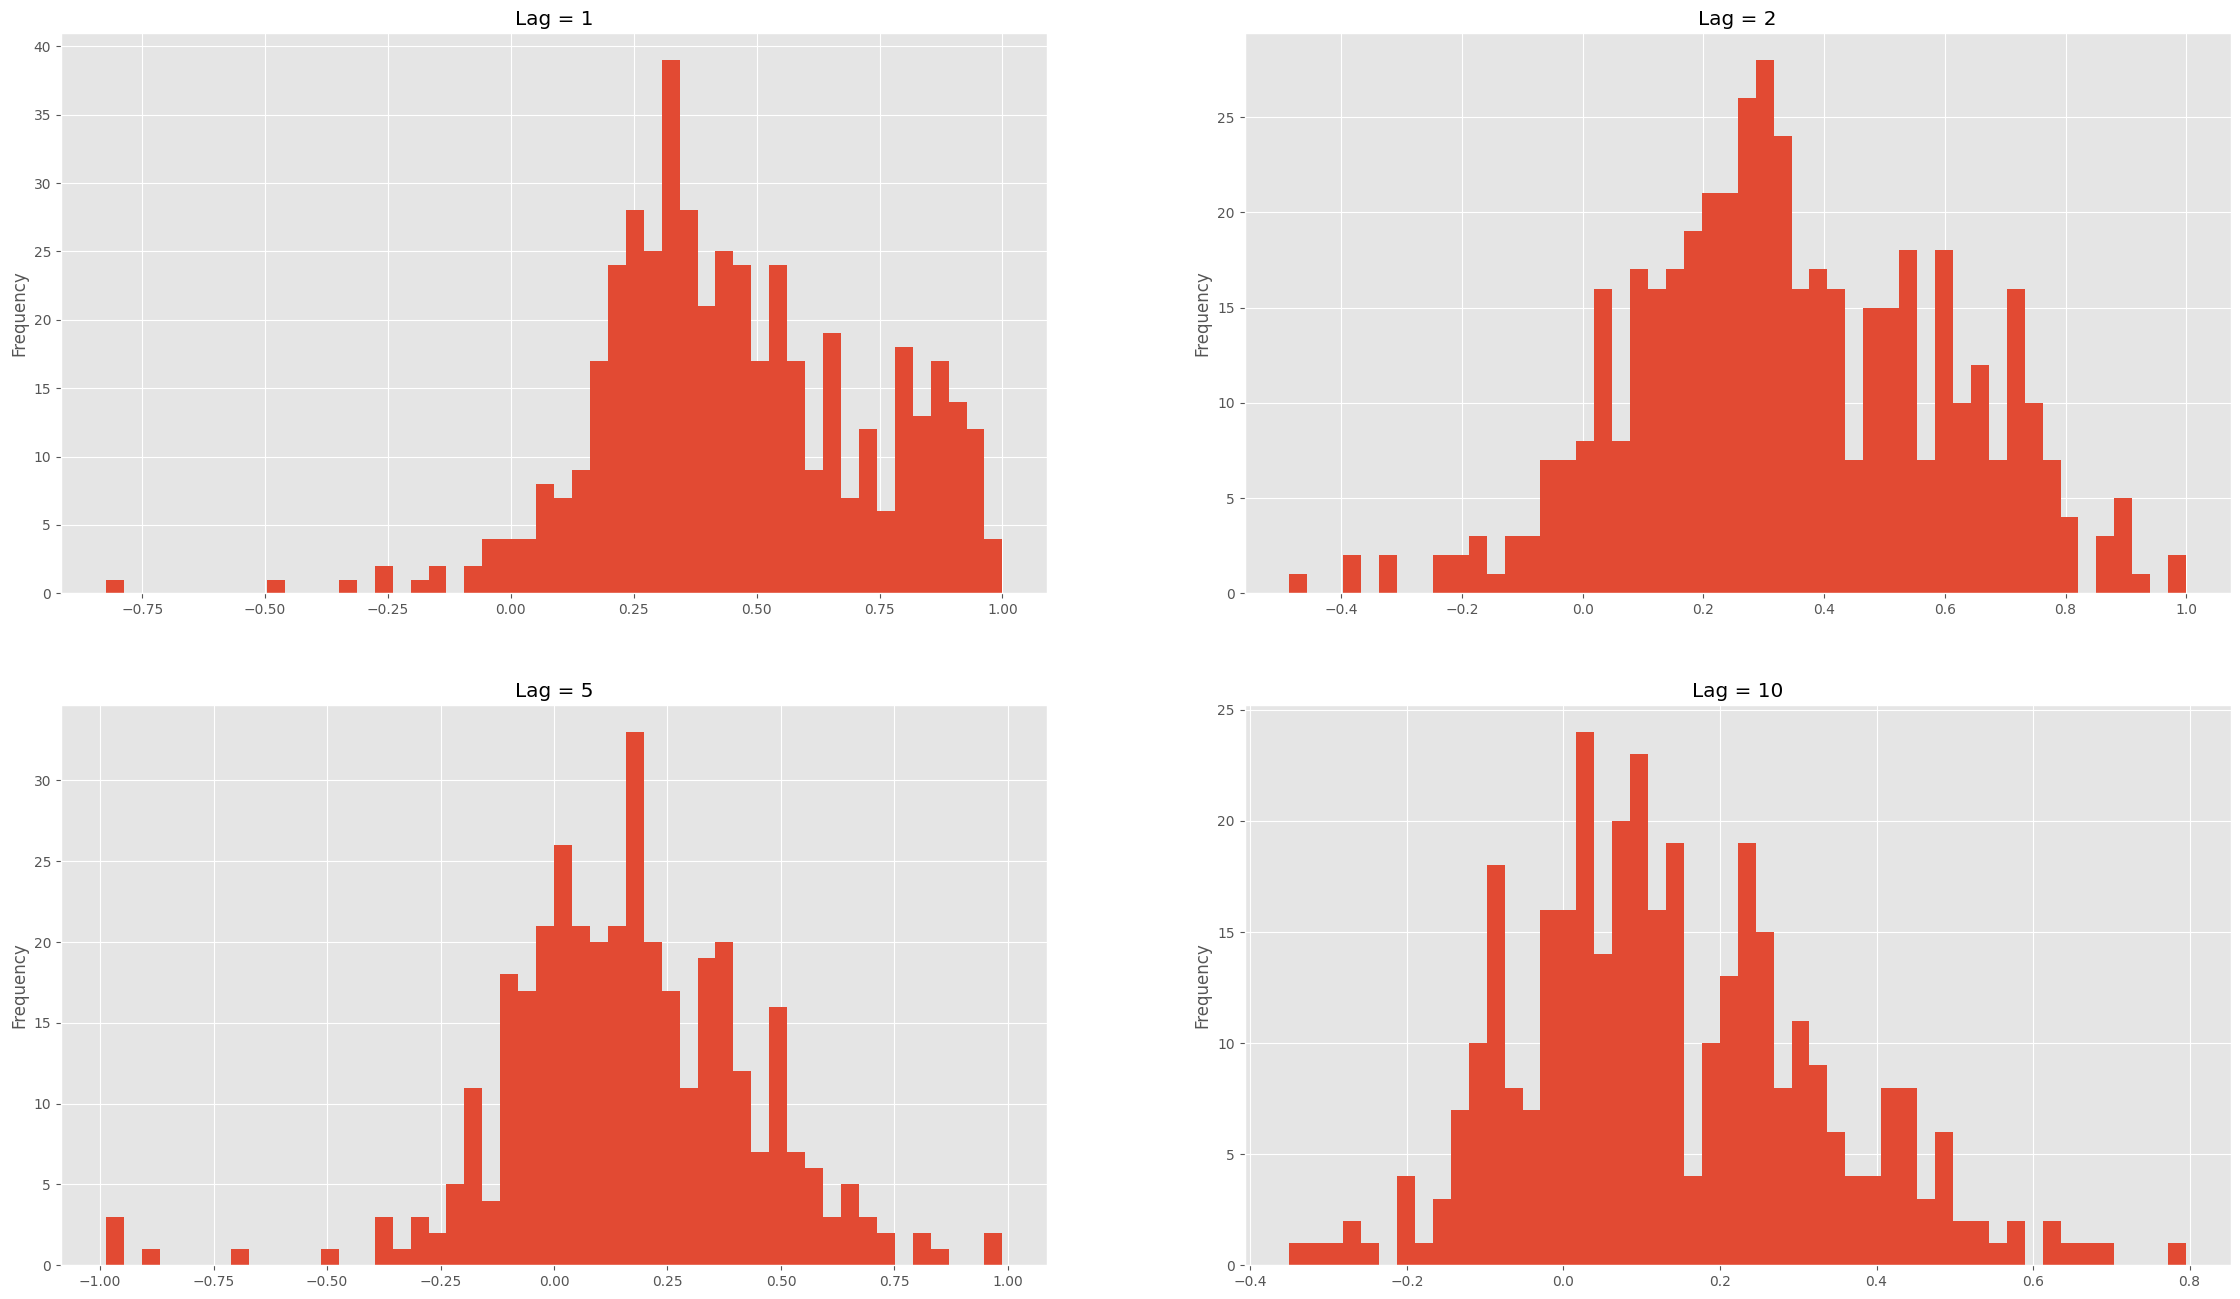

In [7]:
fig, axs = autocorr_plots(log_returns.rolling(10, 5).std().resample("10 D").last())

## Rolling GARCH Fitting

In [30]:
GARCH_KWARGS = {
    "mean": "constant",  # mean model
    "vol": "Garch",  # volatility model
    "dist": "normal",  # distribution for e_t, the standardised residuals
    "p": 5, 
    "q": 5,
}

WINDOW = 250
SCALE_FACTOR = 100

In [31]:
def fit_garch(y, **garch_kwargs):
    garch = arch_model(y, rescale=False, **garch_kwargs)
    return garch.fit(disp="off", options={"ftol": 1e-2})


def garch_forecast(y, qty, **garch_kwargs):
    fitted_garch = fit_garch(y, **garch_kwargs)
    return getattr(fitted_garch.forecast(horizon=1), qty).values[-1]


def garch_multi_forecast(arr, qty, **garch_kwargs):
    garch_forecast_ = lambda x: garch_forecast(x, qty, **garch_kwargs)
    return np.apply_along_axis(garch_forecast_, axis=0, arr=arr[:-1])

In [32]:
mean_preds = rolling_df_to_series(SCALE_FACTOR * log_returns, lambda x: garch_multi_forecast(x, "mean", **GARCH_KWARGS), window=WINDOW)

100%|██████████| 3180/3180 [1:51:29<00:00,  2.10s/it]


In [ ]:
vol_preds = rolling_df_to_series(SCALE_FACTOR * log_returns, lambda x: garch_multi_forecast(x, "variance", **GARCH_KWARGS), window=WINDOW)

Look at a few rolling correlations to assess results:

<AxesSubplot: xlabel='date'>

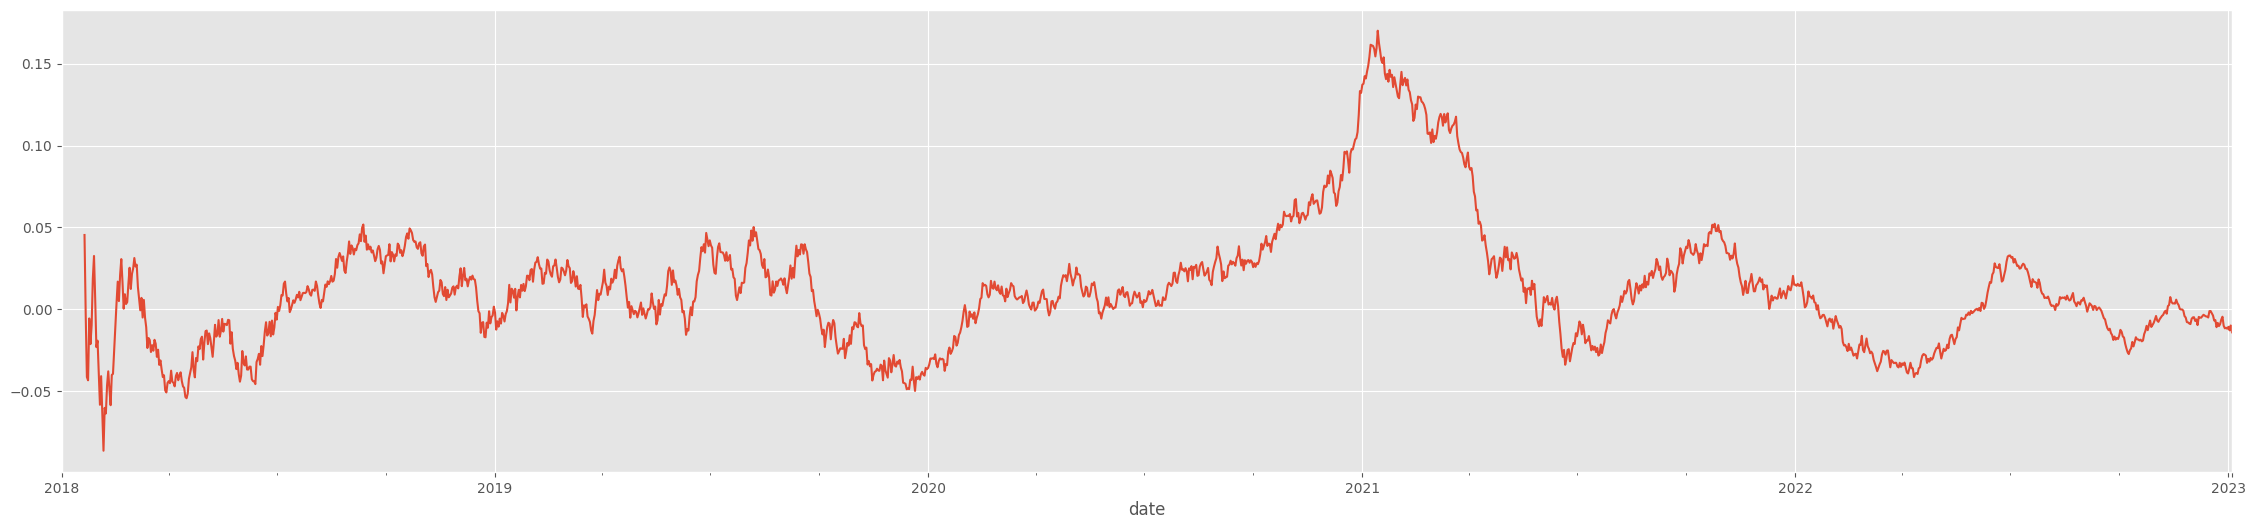

In [61]:
mean_preds.corrwith(log_returns, axis=1)["2018":].rolling(100, 20).mean().plot()

<AxesSubplot: xlabel='date'>

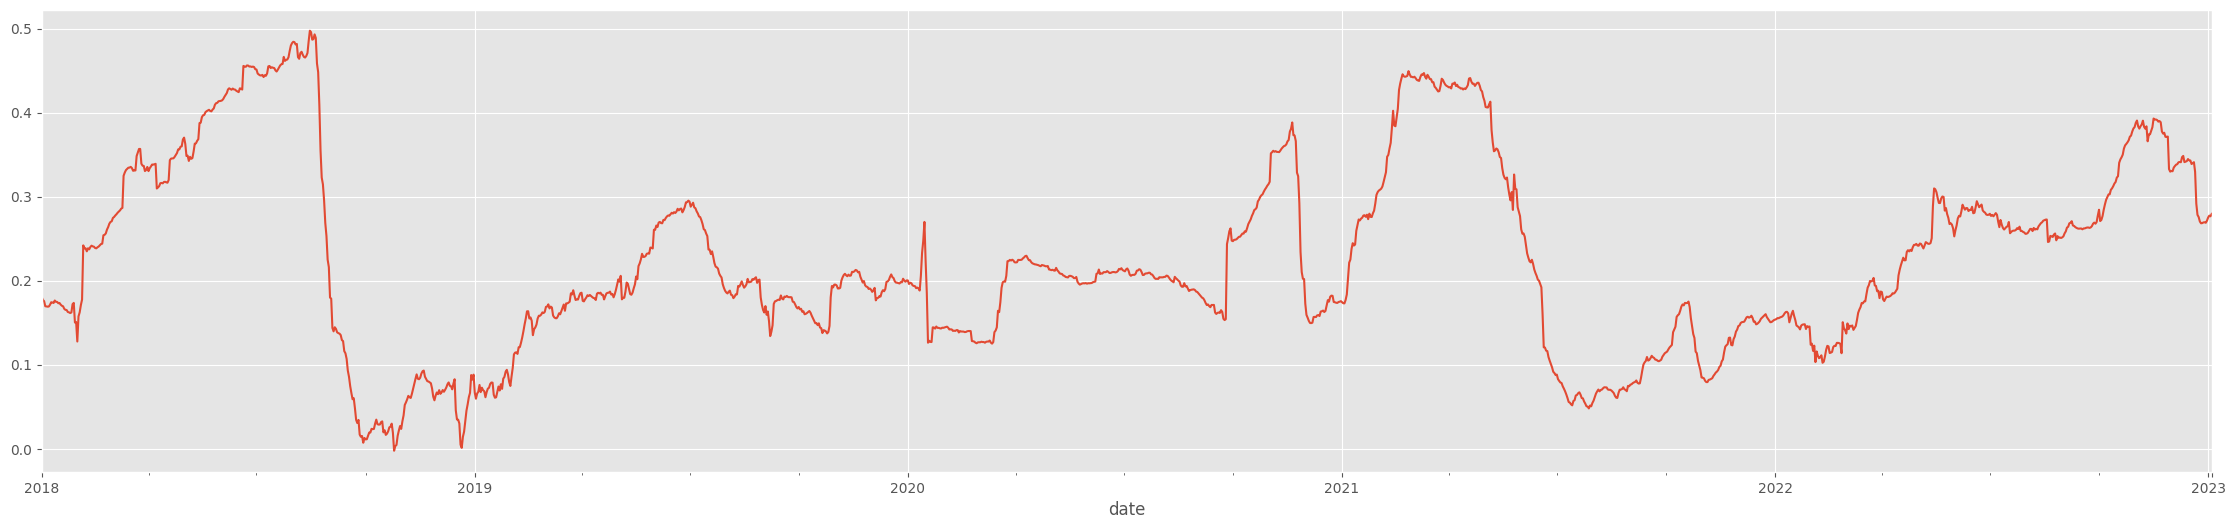

In [62]:
vol_preds.mean(axis=1).rolling(252, 100).corr(log_returns.std(axis=1))["2018":].plot()